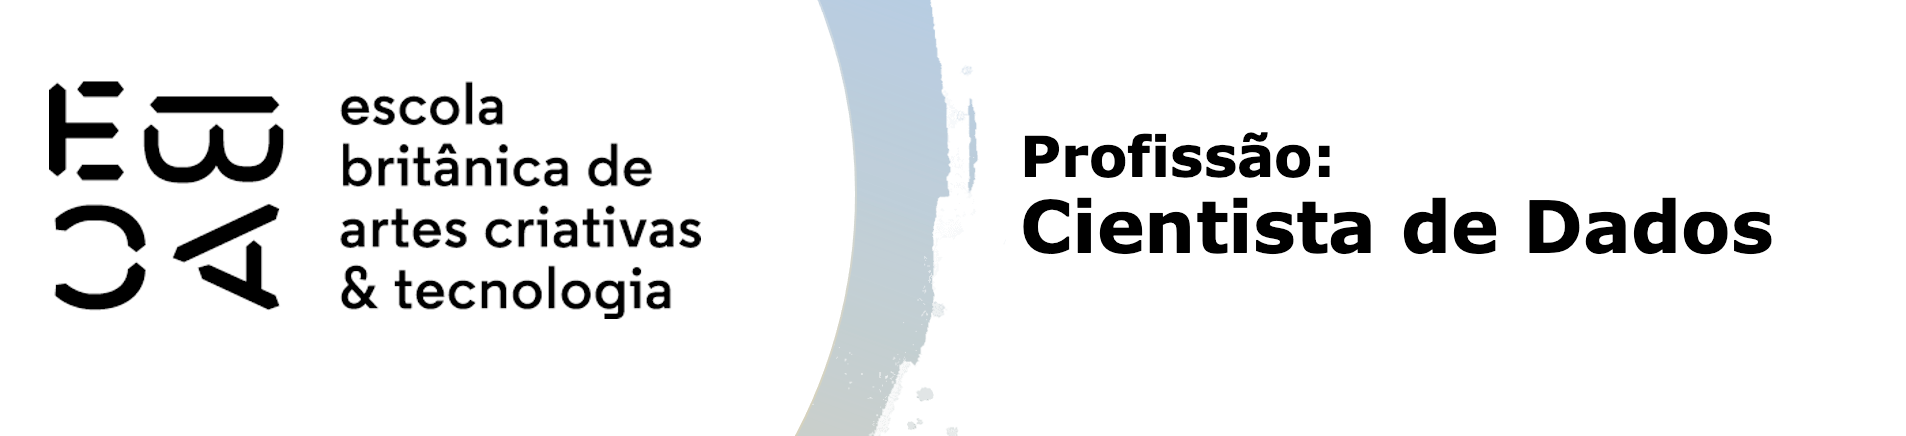

# Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelod e previsão de renda que você fez para esta base. 

- Substitua missings pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado). 

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

In [561]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

from sklearn.metrics import r2_score



In [562]:
df = pd.read_csv('previsao_de_renda_II.csv', index_col=0)
df.drop_duplicates(inplace=True)
df.columns

Index(['index', 'sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos',
       'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'idade',
       'tempo_emprego', 'qt_pessoas_residencia', 'renda'],
      dtype='object')

In [563]:
df['Log_renda'] = np.log(df['renda'])

df['tempo_emprego'].fillna(value=df['tempo_emprego'].mean(), inplace=True)

df_test = df[df.index >= '2016-01-01']
df_train = df[df.index < '2016-01-01']

reg_orig = smf.ols('Log_renda ~ C(sexo) + C(posse_de_veiculo) + C(posse_de_imovel) + qtd_filhos +\
C(tipo_renda) + C(educacao) + C(estado_civil) + C(tipo_residencia) + idade +\
tempo_emprego + qt_pessoas_residencia', data=df_train).fit()
print(reg_orig.summary())

                            OLS Regression Results                            
Dep. Variable:              Log_renda   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     4344.
Date:                Wed, 13 Dec 2023   Prob (F-statistic):               0.00
Time:                        15:17:20   Log-Likelihood:            -1.8581e+05
No. Observations:              138267   AIC:                         3.717e+05
Df Residuals:                  138242   BIC:                         3.719e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

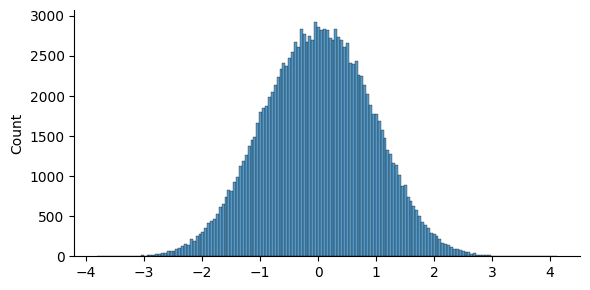

In [564]:
sns.displot(reg_orig.resid, height=3, aspect=2);

In [565]:
pred = reg_orig.predict()

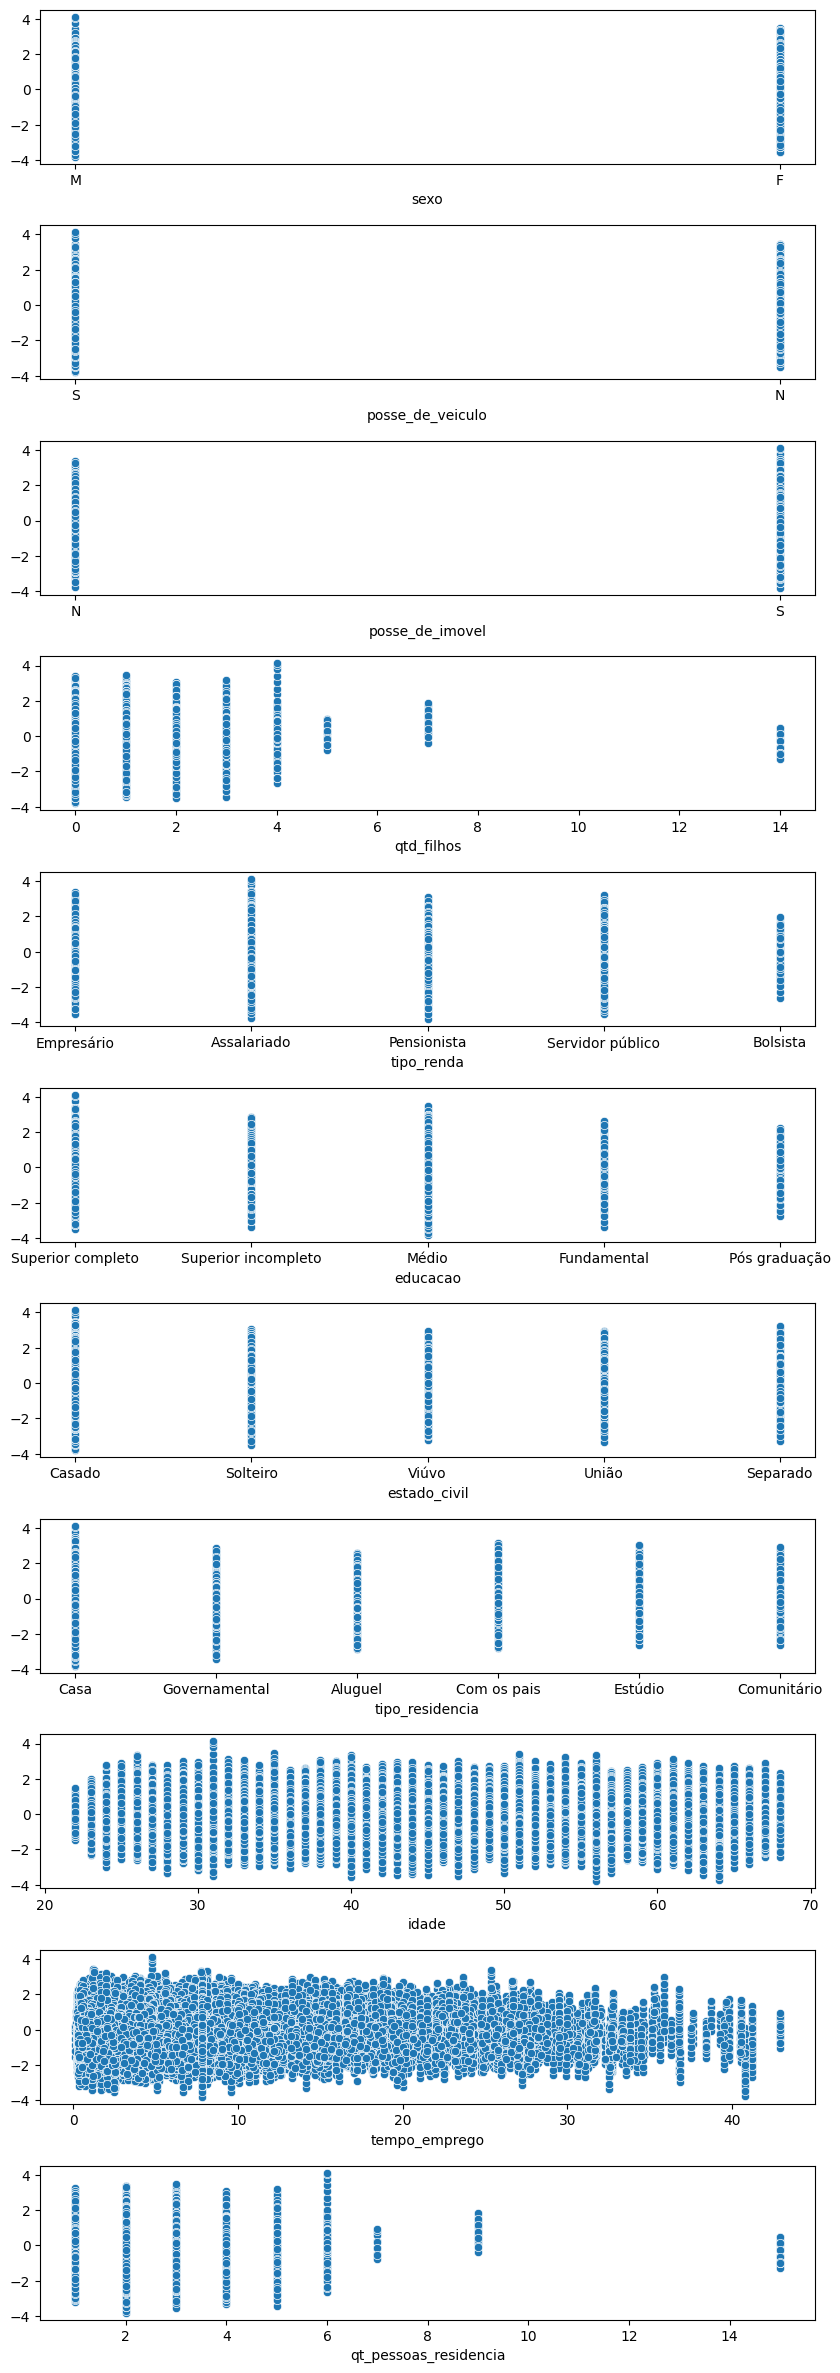

In [566]:
variaveis = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos',
       'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'idade',
       'tempo_emprego', 'qt_pessoas_residencia']

fix, ax = plt.subplots(len(variaveis), figsize=(10,30))
plt.subplots_adjust(hspace=.4)

for i, var in enumerate(variaveis):
    sns.scatterplot(x=df_train[var], y=reg_orig.resid, ax=ax[i])
    

<AxesSubplot: xlabel='data_ref'>

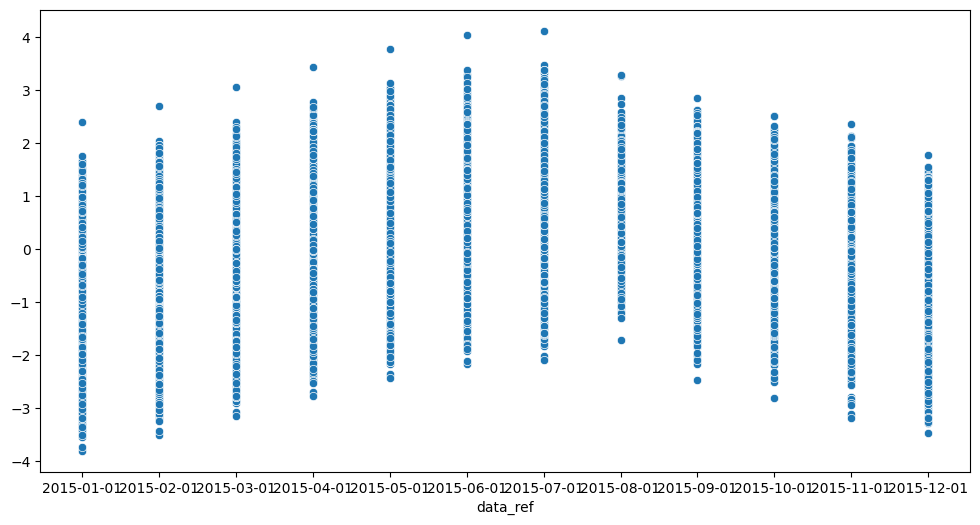

In [567]:
fix, ax = plt.subplots(1, figsize=(12,6))
sns.scatterplot(x=df_train.index, y=reg_orig.resid, ax=ax)

<AxesSubplot: >

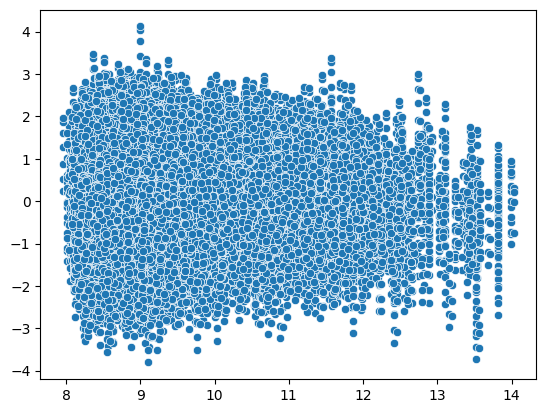

In [568]:
sns.scatterplot(x = reg_orig.predict(), y = reg_orig.resid)

## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

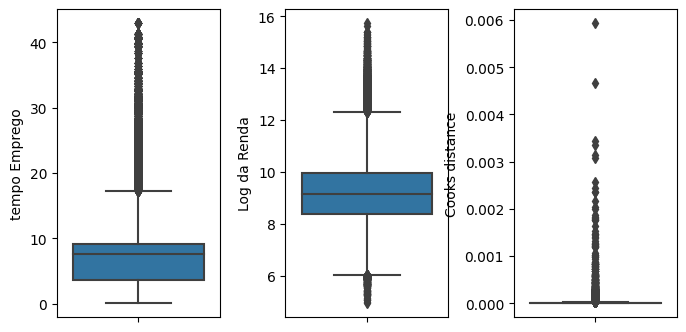

In [569]:
influence = pd.DataFrame(reg_orig.get_influence().cooks_distance[0]).round(6)
# influence

fix, ax = plt.subplots(1, 3, figsize=(8,4))
plt.subplots_adjust(wspace=.4, hspace=0)

sns.boxplot(y = 'tempo_emprego',data=df_train, ax=ax[0])
sns.boxplot(y = 'Log_renda',data=df_train, ax=ax[1])
sns.boxplot(y = influence[0] ,data=df_train, ax=ax[2]);

ax[0].set_ylabel('tempo Emprego')
ax[1].set_ylabel('Log da Renda')
ax[2].set_ylabel('Cooks distance');

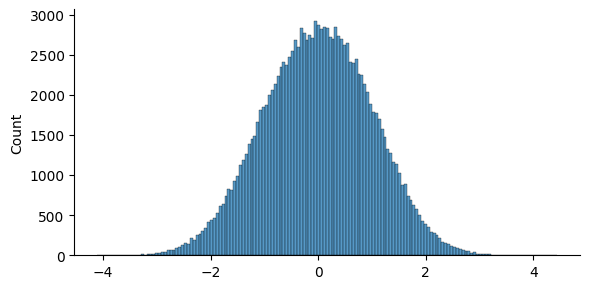

In [570]:
sns.displot(reg_orig.get_influence().resid_studentized, height=3, aspect=2);

## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman

- VIF

In [571]:
df_train[variaveis].corr(method="spearman")

C:\Users\Bruno\AppData\Local\Temp\ipykernel_17252\1071578740.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_train[variaveis].corr(method="spearman")


,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia
qtd_filhos,1.000000,-0.424389,-0.089368,0.826112
idade,-0.424389,1.000000,0.293954,-0.358923
tempo_emprego,-0.089368,0.293954,1.000000,-0.058705
qt_pessoas_residencia,0.826112,-0.358923,-0.058705,1.000000


In [572]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

df_dum = pd.get_dummies(df_train[variaveis], drop_first=True)
vars_vif = pd.DataFrame()
vars_vif["VIF Factor"] = [vif(df_dum, i) for i in range(df_dum.shape[1])]
vars_vif["Feature"] = df_dum.columns

vars_vif.round(2)

,VIF Factor,Feature
0,36.89,qtd_filhos
1,34.94,idade
2,3.02,tempo_emprego
3,259.41,qt_pessoas_residencia
4,1.83,sexo_M
5,1.95,posse_de_veiculo_S
6,3.24,posse_de_imovel_S
7,1.00,tipo_renda_Bolsista
8,1.46,tipo_renda_Empresário
9,2.21,tipo_renda_Pensionista


## Ajustes

Faça os ajustes que julgar necessários no modelo e compare as métricas de desempenho do modelo original e ajustado na base de testes.

In [573]:
# Criação de variáveis ortogonais

df_train_mod = df_train.copy()
df_train_mod = df_train_mod.reset_index()

qf_por_tipo_renda = df_train_mod['qtd_filhos'].groupby(df_train_mod['tipo_renda']).mean()
df_train_mod.loc[:,'qf_por_tipo_renda'] = df_train_mod['qtd_filhos'] - df_train_mod['tipo_renda'].map(qf_por_tipo_renda)

idade_por_tipo_renda = df_train_mod['idade'].groupby(df_train_mod['tipo_renda']).mean()
df_train_mod.loc[:,'idade_por_tipo_renda'] = df_train_mod['idade'] - df_train_mod['tipo_renda'].map(idade_por_tipo_renda)

# te_por_tipo_renda = df_train['tempo_emprego'].groupby(df_train['tipo_renda']).mean()
# df_train_mod.loc[:,'te_por_tipo_renda'] = df_train['tempo_emprego'] - df_train['tipo_renda'].map(te_por_tipo_renda)

variaveis = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qf_por_tipo_renda', 'idade_por_tipo_renda',
       'tipo_renda', 'estado_civil', 'tempo_emprego']
df_train_mod


,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,Log_renda,qf_por_tipo_renda,idade_por_tipo_renda
0,2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14,9.318131,-0.457894,6.766425
1,2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81,7.793508,-0.524314,-11.034866
2,2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66,9.528769,-0.524314,-13.034866
3,2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84,7.767196,1.475686,2.965134
4,2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78,6.673020,1.475686,-8.034866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138262,2015-12-01,8106,F,N,N,0,Servidor público,Superior completo,Casado,Com os pais,47,25.652055,2.0,81045.93,11.302771,-0.549534,5.409389
138263,2015-12-01,15068,F,S,S,0,Pensionista,Superior completo,Casado,Governamental,64,7.787045,2.0,2577.79,7.854688,-0.042026,4.739839
138264,2015-12-01,5339,M,S,S,2,Assalariado,Superior completo,União,Casa,35,13.186301,4.0,16696.95,9.722981,1.475686,-6.034866
138265,2015-12-01,4928,M,S,N,0,Assalariado,Superior completo,Solteiro,Casa,25,3.049315,1.0,780.51,6.659948,-0.524314,-16.034866


(128136, 18)

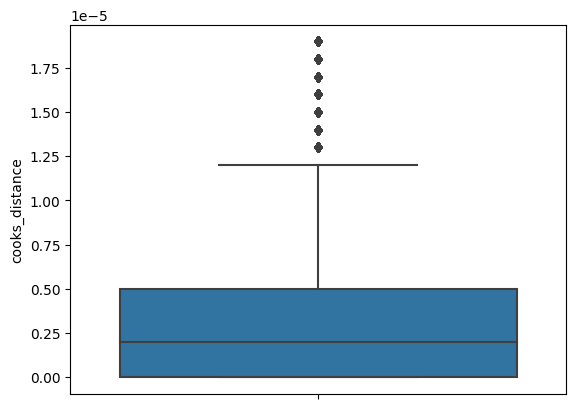

In [574]:
# Retirando Outliers

df_train_mod['cooks_distance'] = influence[0]
df_train_mod = df_train_mod.query('cooks_distance < 0.00002')
sns.boxplot(y = 'cooks_distance' ,data=df_train_mod);
df_train_mod.shape

In [575]:
df_train_mod[variaveis].corr(method="spearman")

C:\Users\Bruno\AppData\Local\Temp\ipykernel_17252\1085445194.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_train_mod[variaveis].corr(method="spearman")


,qf_por_tipo_renda,idade_por_tipo_renda,tempo_emprego
qf_por_tipo_renda,1.000000,-0.328941,-0.058499
idade_por_tipo_renda,-0.328941,1.000000,0.236965
tempo_emprego,-0.058499,0.236965,1.000000


In [576]:
df_dum = pd.get_dummies(df_train_mod[variaveis], drop_first=True)
vars_vif = pd.DataFrame()
vars_vif["VIF Factor"] = [vif(df_dum, i) for i in range(df_dum.shape[1])]
vars_vif["Feature"] = df_dum.columns

vars_vif.round(2)

,VIF Factor,Feature
0,1.14,qf_por_tipo_renda
1,1.24,idade_por_tipo_renda
2,2.18,tempo_emprego
3,1.67,sexo_M
4,1.82,posse_de_veiculo_S
5,2.30,posse_de_imovel_S
6,1.00,tipo_renda_Bolsista
7,1.31,tipo_renda_Empresário
8,1.36,tipo_renda_Pensionista
9,1.15,tipo_renda_Servidor público


In [577]:
" + ".join(variaveis)

'sexo + posse_de_veiculo + posse_de_imovel + qf_por_tipo_renda + idade_por_tipo_renda + tipo_renda + estado_civil + tempo_emprego'

In [578]:
reg_novo = smf.ols('Log_renda ~ sexo + posse_de_veiculo + posse_de_imovel + qf_por_tipo_renda + idade_por_tipo_renda + tipo_renda + estado_civil + tempo_emprego', data=df_train_mod).fit()
print(reg_novo.summary())

                            OLS Regression Results                            
Dep. Variable:              Log_renda   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     8311.
Date:                Wed, 13 Dec 2023   Prob (F-statistic):               0.00
Time:                        15:17:49   Log-Likelihood:            -1.5757e+05
No. Observations:              128136   AIC:                         3.152e+05
Df Residuals:                  128121   BIC:                         3.153e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

<AxesSubplot: >

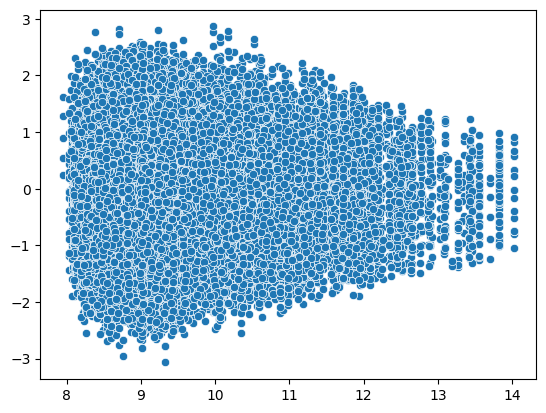

In [579]:
sns.scatterplot(x = reg_novo.predict(), y = reg_novo.resid)

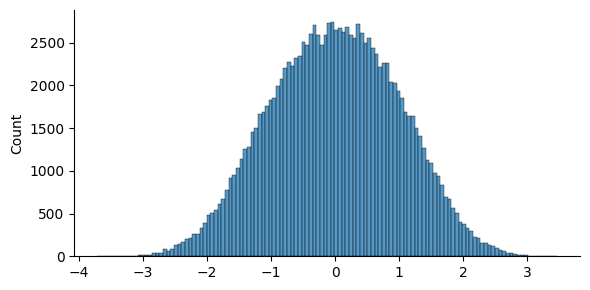

In [580]:
sns.displot(reg_novo.get_influence().resid_studentized, height=3, aspect=2);

In [581]:
print(f"O primeiro modelo possui um R² de :{reg_orig.rsquared}")
print(f"O modelo alterado possui um R² de :{reg_novo.rsquared}")

O primeiro modelo possui um R² de :0.4299170241531661
O modelo alterado possui um R² de :0.4759292548996076
